In [1]:
from pyscf import gto, scf, cc
import numpy as np
from jax import numpy as jnp
from jax import vmap, jvp, jit
import jax
from functools import partial

a = 1.5 # 2aB
nH = 2
atoms = ""
for i in range(nH):
    atoms += f"H {i*a:.5f} 0.00000 0.00000 \n"

mol = gto.M(atom=atoms, basis="crenbl", verbose=4)
mol.build()

mf = scf.RHF(mol)#.density_fit()
e = mf.kernel()

mycc = cc.CCSD(mf)
e = mycc.kernel()

System: uname_result(system='Linux', node='yichi-thinkpad', release='4.4.0-26100-Microsoft', version='#5074-Microsoft Fri Jan 01 08:00:00 PST 2016', machine='x86_64')  Threads 12
Python 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
numpy 1.24.3  scipy 1.14.1  h5py 3.12.1
Date: Mon Oct  6 21:48:46 2025
PySCF version 2.8.0
PySCF path  /home/yichi/research/software/lno_pyscf
GIT HEAD (branch master) ef75f4190e4de208685670651dc6c467f72b6794

[ENV] PYSCF_EXT_PATH /home/yichi/research/software/pyscf
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.00

In [22]:
import numpy as np
from matplotlib import pyplot as plt
nH = np.array([4,8,12,16,20,24,28])
ccsd = np.array([-2.180959,-4.361918,-6.5428774,-8.7238366,-10.9047958,-13.085755,-15.266714])
afqmc = np.array([-2.180749,-4.359989,-6.537909,-8.714803,-10.890811,-13.066010,-15.240477])
afqmc_err = np.array([0.000004,0.000014,0.000023,0.000028,0.000034,0.000044,0.000060])

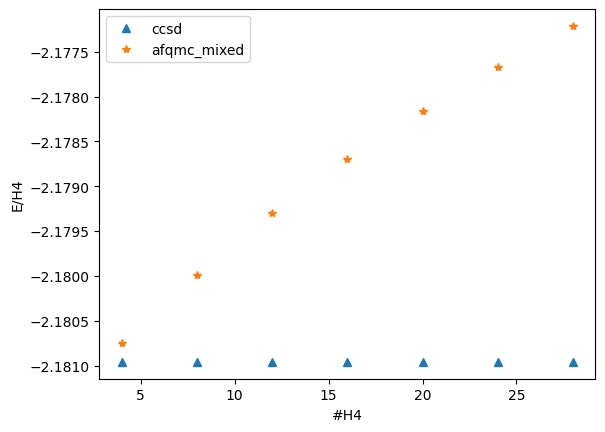

In [25]:
n = nH/4
plt.plot(nH,ccsd/n,'^',label='ccsd')
plt.plot(nH,afqmc/n,'*',label='afqmc_mixed')
plt.legend()
plt.xlabel('#H4')
plt.ylabel('E/H4')
plt.show()

In [ ]:
# N x H2 just set ovl to 1
# AFQMC energy: -1.150512 +/- 0.001077
# AFQMC energy: -2.395787 +/- 0.003558
# AFQMC energy: -3.736988 +/- 0.004094
print(-1.150512*2,-1.150512*3)

-2.301024 -3.451536


In [2]:
options = {'n_eql': 4,
           'n_prop_steps': 10,
            'n_ene_blocks': 1,
            'n_sr_blocks': 10,
            'n_blocks': 10,
            'n_walkers': 2,
            'seed': 2,
            'walker_type': 'rhf',
            'trial': 'cisd',
            'dt':0.005,
            'free_projection':False,
            'ad_mode':None,
            'use_gpu': False,
            }

In [4]:
from ad_afqmc import pyscf_interface, mpi_jax, wavefunctions
from ad_afqmc.mix_cisd_hf import propgate_mix

pyscf_interface.prep_afqmc(mycc,chol_cut=1e-7)
ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ \
    = (mpi_jax._prep_afqmc(options))

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (1, 1)
# Number of basis functions: 8
# Number of Cholesky vectors: 26
#
# Number of MPI ranks: 1
#
# norb: 8
# nelec: (1, 1)
#
# n_eql: 4
# n_prop_steps: 10
# n_ene_blocks: 1
# n_sr_blocks: 10
# n_blocks: 10
# n_walkers: 2
# seed: 2
# walker_type: rhf
# trial: cisd
# dt: 0.005
# free_projection: False
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#


In [13]:
print(wave_data['ci1'].shape)
print(wave_data['ci2'].shape)

(1, 7)
(1, 7, 1, 7)


In [14]:
print(ham_data['h1'].shape[1])

8


In [17]:
nao = trial.norb
nocc = wave_data['ci1'].shape[0]
wave_data["mo_coeff"] = np.eye(nao)[:,:nocc]

In [18]:
print(wave_data['mo_coeff'])

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [5]:
from mpi4py import MPI
from jax import random

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
seed = options["seed"]
neql = options["n_eql"]

# trial_rdm1 = trial.get_rdm1(wave_data)
# if "rdm1" not in wave_data:
#     wave_data["rdm1"] = trial_rdm1

ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)

init_walkers = None
prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
prop_data['n_killed_walkers'] = 0
prop_data["key"] = random.PRNGKey(seed + rank)
init_walker = prop_data['walkers'][0]
print(prop_data['e_estimate'])
print(mycc.e_tot)
print(prop_data['e_estimate']-mycc.e_tot)
# e_pt,e_og = _calc_ept(init_walker, ham_data, wave_data)
# print(e_pt,e_og)
# print(e_pt-e_og)
# e_pt,e_og = calc_ept(prop_data['walkers'], ham_data, wave_data)
# print(e_pt)
# print(e_og)

-1.056483939212803
-1.0564839416902816
2.4774786666625914e-09


In [ ]:
prop_data['esmi']

cisd(norb=8, nelec=(1, 1), n_batch=1)

In [ ]:
@partial(jit, static_argnums=(0, 1))
def propagate_mix(
    prop,
    trial,
    ham_data: dict,
    prop_data: dict,
    fields: jax.Array,
    wave_data: dict,
) -> dict:
    """Phaseless AFQMC propagation.

    Args:
        trial: trial wave function handler
        ham_data: dictionary containing the Hamiltonian data
        prop_data: dictionary containing the propagation data
        fields: auxiliary fields
        wave_data: wave function data

    Returns:
        prop_data: dictionary containing the updated propagation data
    """
    guide = wavefunctions.rhf(trial.norb,trial.nelec,trial.n_batch)
    force_bias = guide.calc_force_bias(prop_data["walkers"], ham_data, wave_data)
    field_shifts = -jnp.sqrt(prop.dt) * (1.0j * force_bias - ham_data["mf_shifts"])
    shifted_fields = fields - field_shifts
    shift_term = jnp.sum(shifted_fields * ham_data["mf_shifts"], axis=1)
    fb_term = jnp.sum(
        fields * field_shifts - field_shifts * field_shifts / 2.0, axis=1
    )

    prop_data["walkers"] = prop._apply_trotprop(
        ham_data, prop_data["walkers"], shifted_fields
    )

    overlaps_new = guide.calc_overlap(prop_data["walkers"], wave_data)
    imp_fun = (
        jnp.exp(
            -jnp.sqrt(prop.dt) * shift_term
            + fb_term
            + prop.dt * (prop_data["pop_control_ene_shift"] + ham_data["h0_prop"])
        )
        * overlaps_new
        / prop_data["overlaps"]
    )
    theta = jnp.angle(
        jnp.exp(-jnp.sqrt(prop.dt) * shift_term)
        * overlaps_new
        / prop_data["overlaps"]
    )
    imp_fun_phaseless = jnp.abs(imp_fun) * jnp.cos(theta)
    imp_fun_phaseless = jnp.array(
        jnp.where(jnp.isnan(imp_fun_phaseless), 0.0, imp_fun_phaseless)
    )
    imp_fun_phaseless = jnp.where(
        imp_fun_phaseless < 1.0e-3, 0.0, imp_fun_phaseless
    )
    imp_fun_phaseless = jnp.where(imp_fun_phaseless > 100.0, 0.0, imp_fun_phaseless)
    # prop_data["imp_fun"] = imp_fun_phaseless
    prop_data["weights"] = imp_fun_phaseless * prop_data["weights"]
    prop_data["weights"] = jnp.array(
        jnp.where(prop_data["weights"] > 100, 0.0, prop_data["weights"])
    )
    prop_data["pop_control_ene_shift"] = prop_data["e_estimate"] - 0.1 * jnp.array(
        jnp.log(jnp.sum(prop_data["weights"]) / prop.n_walkers) / prop.dt
    )
    prop_data["overlaps"] = overlaps_new
    return prop_data

In [ ]:
prop_data, (block_energy, block_weight) \
    = sampler._block_scan(prop_data,None,ham_data,prop,trial,wave_data)

ValueError: Non-hashable static arguments are not supported, as this can lead to unexpected cache-misses. Static argument (index 5) of type <class 'dict'> for function _block_scan is non-hashable.

In [5]:
trial._calc_energy_restricted(prop_data['walkers'][0], ham_data, wave_data)

NameError: name 'prop_data' is not defined